# **트레이딩 전략과 구현 6장 포트폴리오 이론**
**[파이썬 증권 데이터 분석 6장](https://nbviewer.jupyter.org/github/INVESTAR/StockAnalysisInPython/tree/master/06_Trading_Strategy/)**
 | **[nbviewer](https://github.com/INVESTAR/StockAnalysisInPython/blob/master/06_Trading_Strategy/ch06_01_EfficientFrontier.py)** | **[Markdown Wiki](https://ko.wikipedia.org/wiki/%EC%9C%84%ED%82%A4%EB%B0%B1%EA%B3%BC:TeX_%EB%AC%B8%EB%B2%95)** | **[Markdown Editor](http://www.hostmath.com/)**


# **1 효율적 투자선**
## **01 데이터 불러오기 및 확인**
- 삼성, 현대차, Naver, HMM 효율투자선 분석
- **[FinanceDataReader](https://github.com/FinanceData/FinanceDataReader)** | **[yfinance](https://github.com/ranaroussi/yfinance)**

In [1]:
DATA_FILENAME = 'data/efficient-frontier.pkl'

# 효율적 투자선 분석기업 Codes
code_dict = {"005930":"삼성전자", "005380":"현대차", "011200":"HMM", "035420":"NAVER"}
import pandas as pd
import FinanceDataReader as fdr
try:
    data_df = pd.read_pickle(DATA_FILENAME)
except FileNotFoundError:
    data_df = [fdr.DataReader(_, start="2019-1-1")['Close'] for _ in code_dict.keys()]
    data_df = pd.concat(data_df, axis=1)
    data_df.columns = list(code_dict.values())
    data_df.to_pickle(DATA_FILENAME)
data_df.head(3)

삼성전자     현대차   HMM   NAVER
Date                                   
2019-01-02  38750  114000  3750  118000
2019-01-03  37600  116500  3670  122000
2019-01-04  37450  119500  3635  125500

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading ... Visualization Modules
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.font_manager import fontManager as fm # 한글폰트 확인 및 추가
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']
for _ in font_list_check:
    font_counts = [f  for f in font_list_check if _ in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: print(f"found : {_}"); plt.rc('font', family=_); break 

found : D2Coding


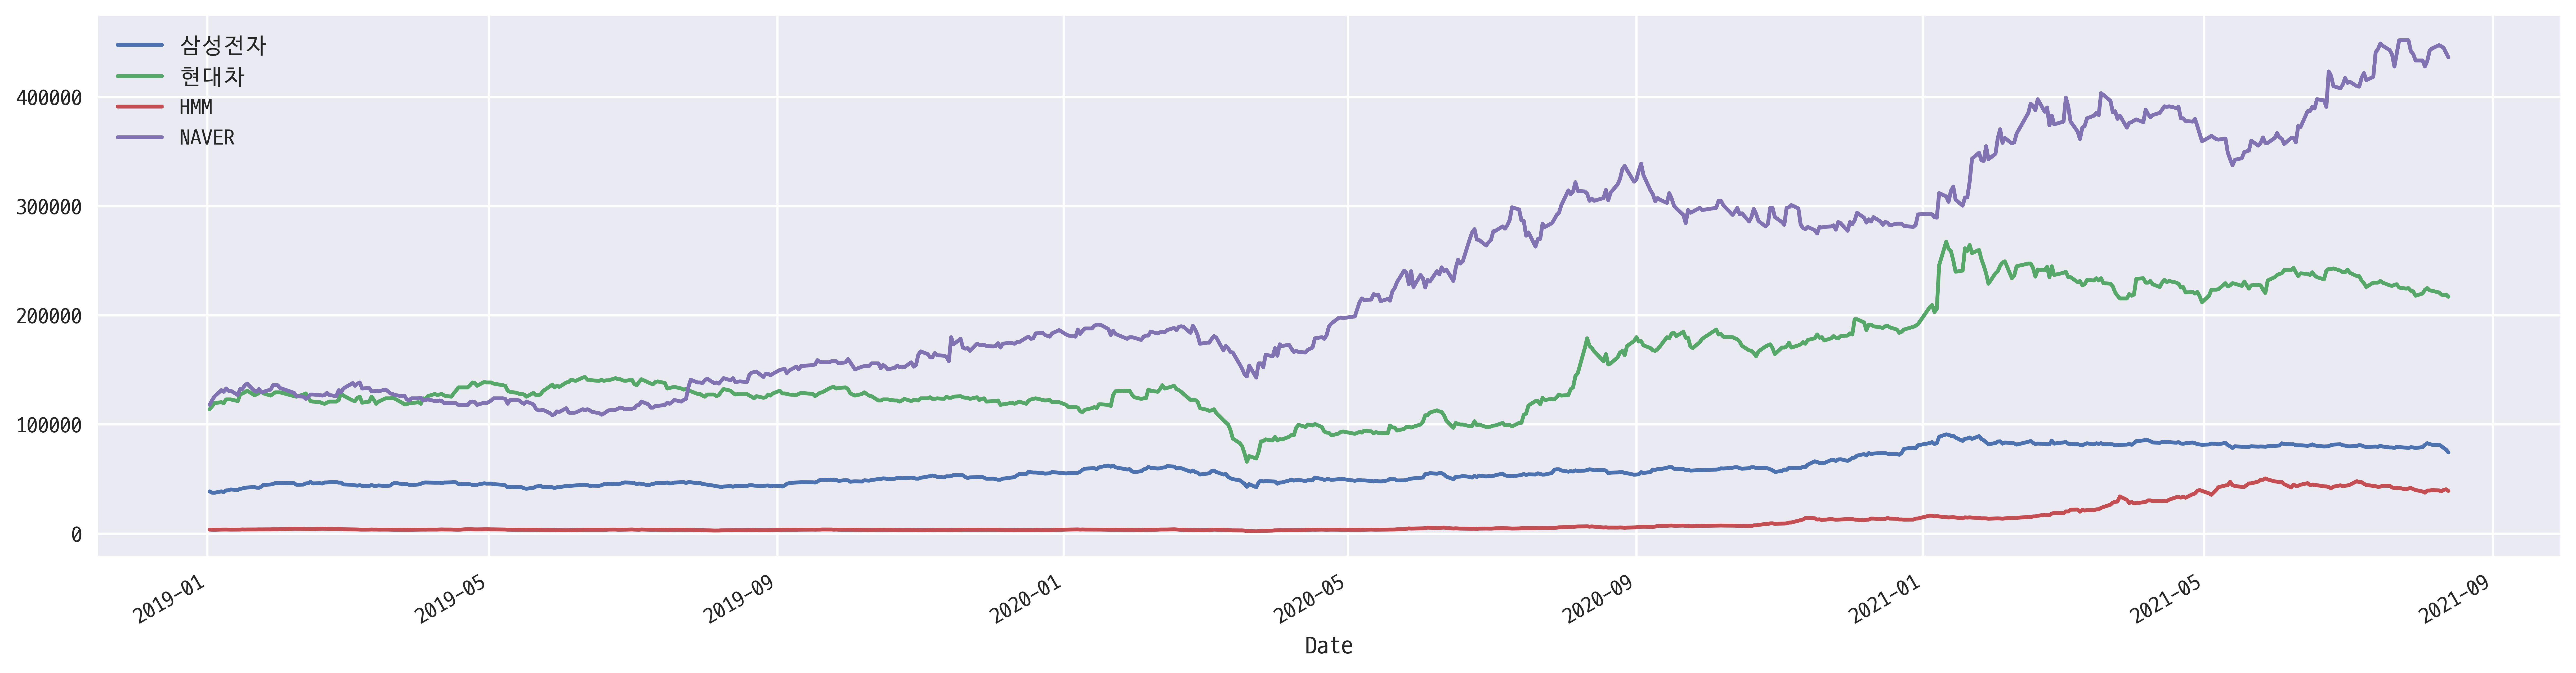

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (20.0, 5.0)
data_df.plot()
plt.show()

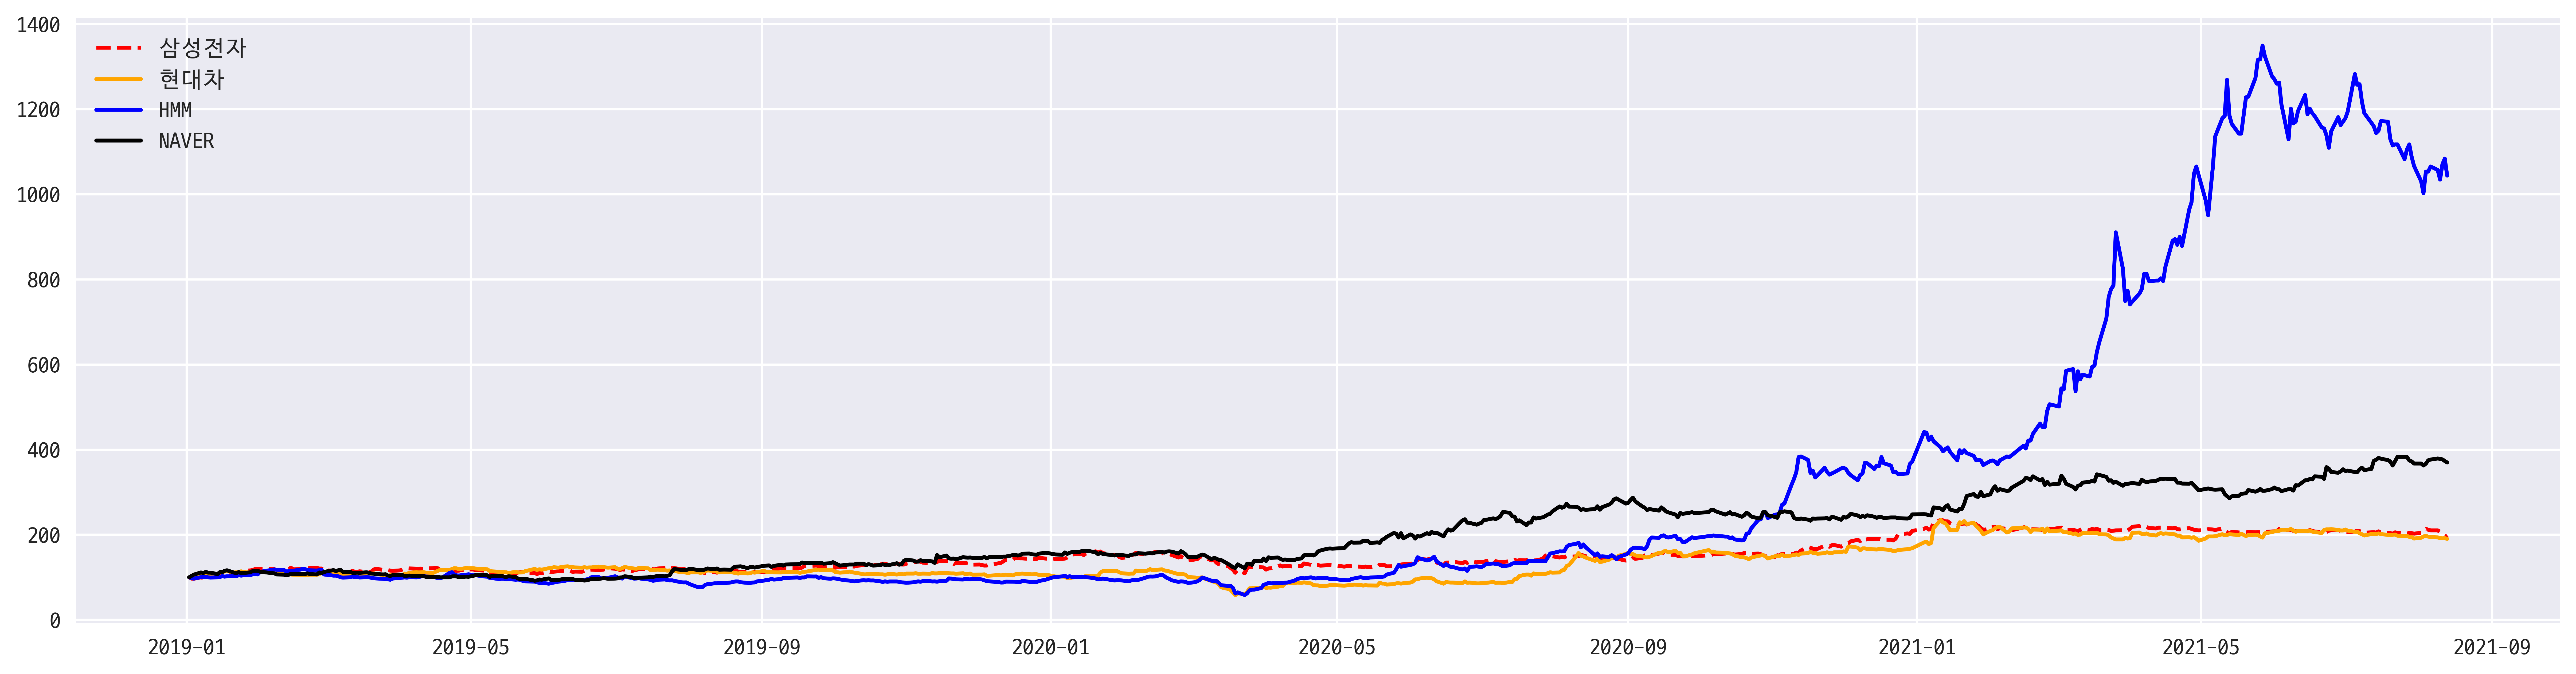

In [4]:
# 기준대비 상승률 비교
data_init = data_df.index[0].strftime('%Y-%m-%d')
data_df_exp = [data_df[_] / data_df[_][data_init] * 100  for _ in data_df.columns]
colors = ['r--', 'orange', 'b', 'k']
for data, color, columns  in zip(data_df_exp, colors, data_df.columns):
    plt.plot(data, color, label=columns)
plt.legend(loc='best'); plt.grid(True); plt.show()

## **02 파생데이터 생성하기**
연간/ 일간 수익률, 연간/ 일간 리스크

In [5]:
# 일간 수익률
daily_rate = data_df.pct_change()
daily_rate.head(3)

삼성전자       현대차       HMM     NAVER
Date                                              
2019-01-02       NaN       NaN       NaN       NaN
2019-01-03 -0.029677  0.021930 -0.021333  0.033898
2019-01-04 -0.003989  0.025751 -0.009537  0.028689

In [6]:
# 연간 수익률
annual_rate = daily_rate.mean() * 252   
annual_rate

삼성전자     0.290806
현대차      0.326257
HMM      1.054776
NAVER    0.573066
dtype: float64

In [7]:
# 일간 리스크 : 변동률의 공분산
daily_cov = daily_rate.cov()
daily_cov

삼성전자       현대차       HMM     NAVER
삼성전자   0.000296  0.000214  0.000139  0.000119
현대차    0.000214  0.000617  0.000231  0.000145
HMM    0.000139  0.000231  0.001135  0.000096
NAVER  0.000119  0.000145  0.000096  0.000514

In [8]:
# 연간 리스크 : 일간 공분산 * 252
annual_cov = daily_cov * 252
annual_cov

삼성전자       현대차       HMM     NAVER
삼성전자   0.074539  0.053944  0.035124  0.030071
현대차    0.053944  0.155575  0.058109  0.036481
HMM    0.035124  0.058109  0.286110  0.024114
NAVER  0.030071  0.036481  0.024114  0.129540

## **03 몬테카를로 시뮬레이션**
- 포트폴리오 20,000 개 생성한 뒤 분석한 최적의 포트폴리오 비율 계산
- 포트폴리오 Risk (표준편차 활용) = $\sqrt{(종목별 비중)T((종목별 연간공분산) (종목별 비중))} $

In [9]:
# 몬테카를로 시뮬레이션
import numpy as np
stocks = list(code_dict.values())
port_rate, port_risk, port_weights = [], [], []
for _ in range(20000):
    # 포트폴리오 비중 난수생성 (합 1이 되도록 정규화)
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 
    # 포트폴리오 수익률/ Risk 시뮬레이션
    returns = np.dot(weights, annual_rate) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 
    port_weights.append(weights)
    port_rate.append(returns) 
    port_risk.append(risk) 

# 포트폴리오 비율과 위험 데이터 dict() 추가
portfolio = {'Returns': port_rate, 'Risk': port_risk} 
# dict() 데이터에 기업별 세부비율 추가
for _, s in enumerate(stocks): # 수익률과 위험률 추가
    portfolio[s] = [weight[_]  for weight in port_weights]
portfolio_df = pd.DataFrame(portfolio) # dict() 데이터 DataFrame 변환
portfolio_df.tail(3)

Returns      Risk      삼성전자       현대차       HMM     NAVER
19997  0.453636  0.264185  0.225657  0.392892  0.085597  0.295854
19998  0.474743  0.265898  0.260673  0.387363  0.147099  0.204866
19999  0.567792  0.269265  0.363848  0.185734  0.297413  0.153005

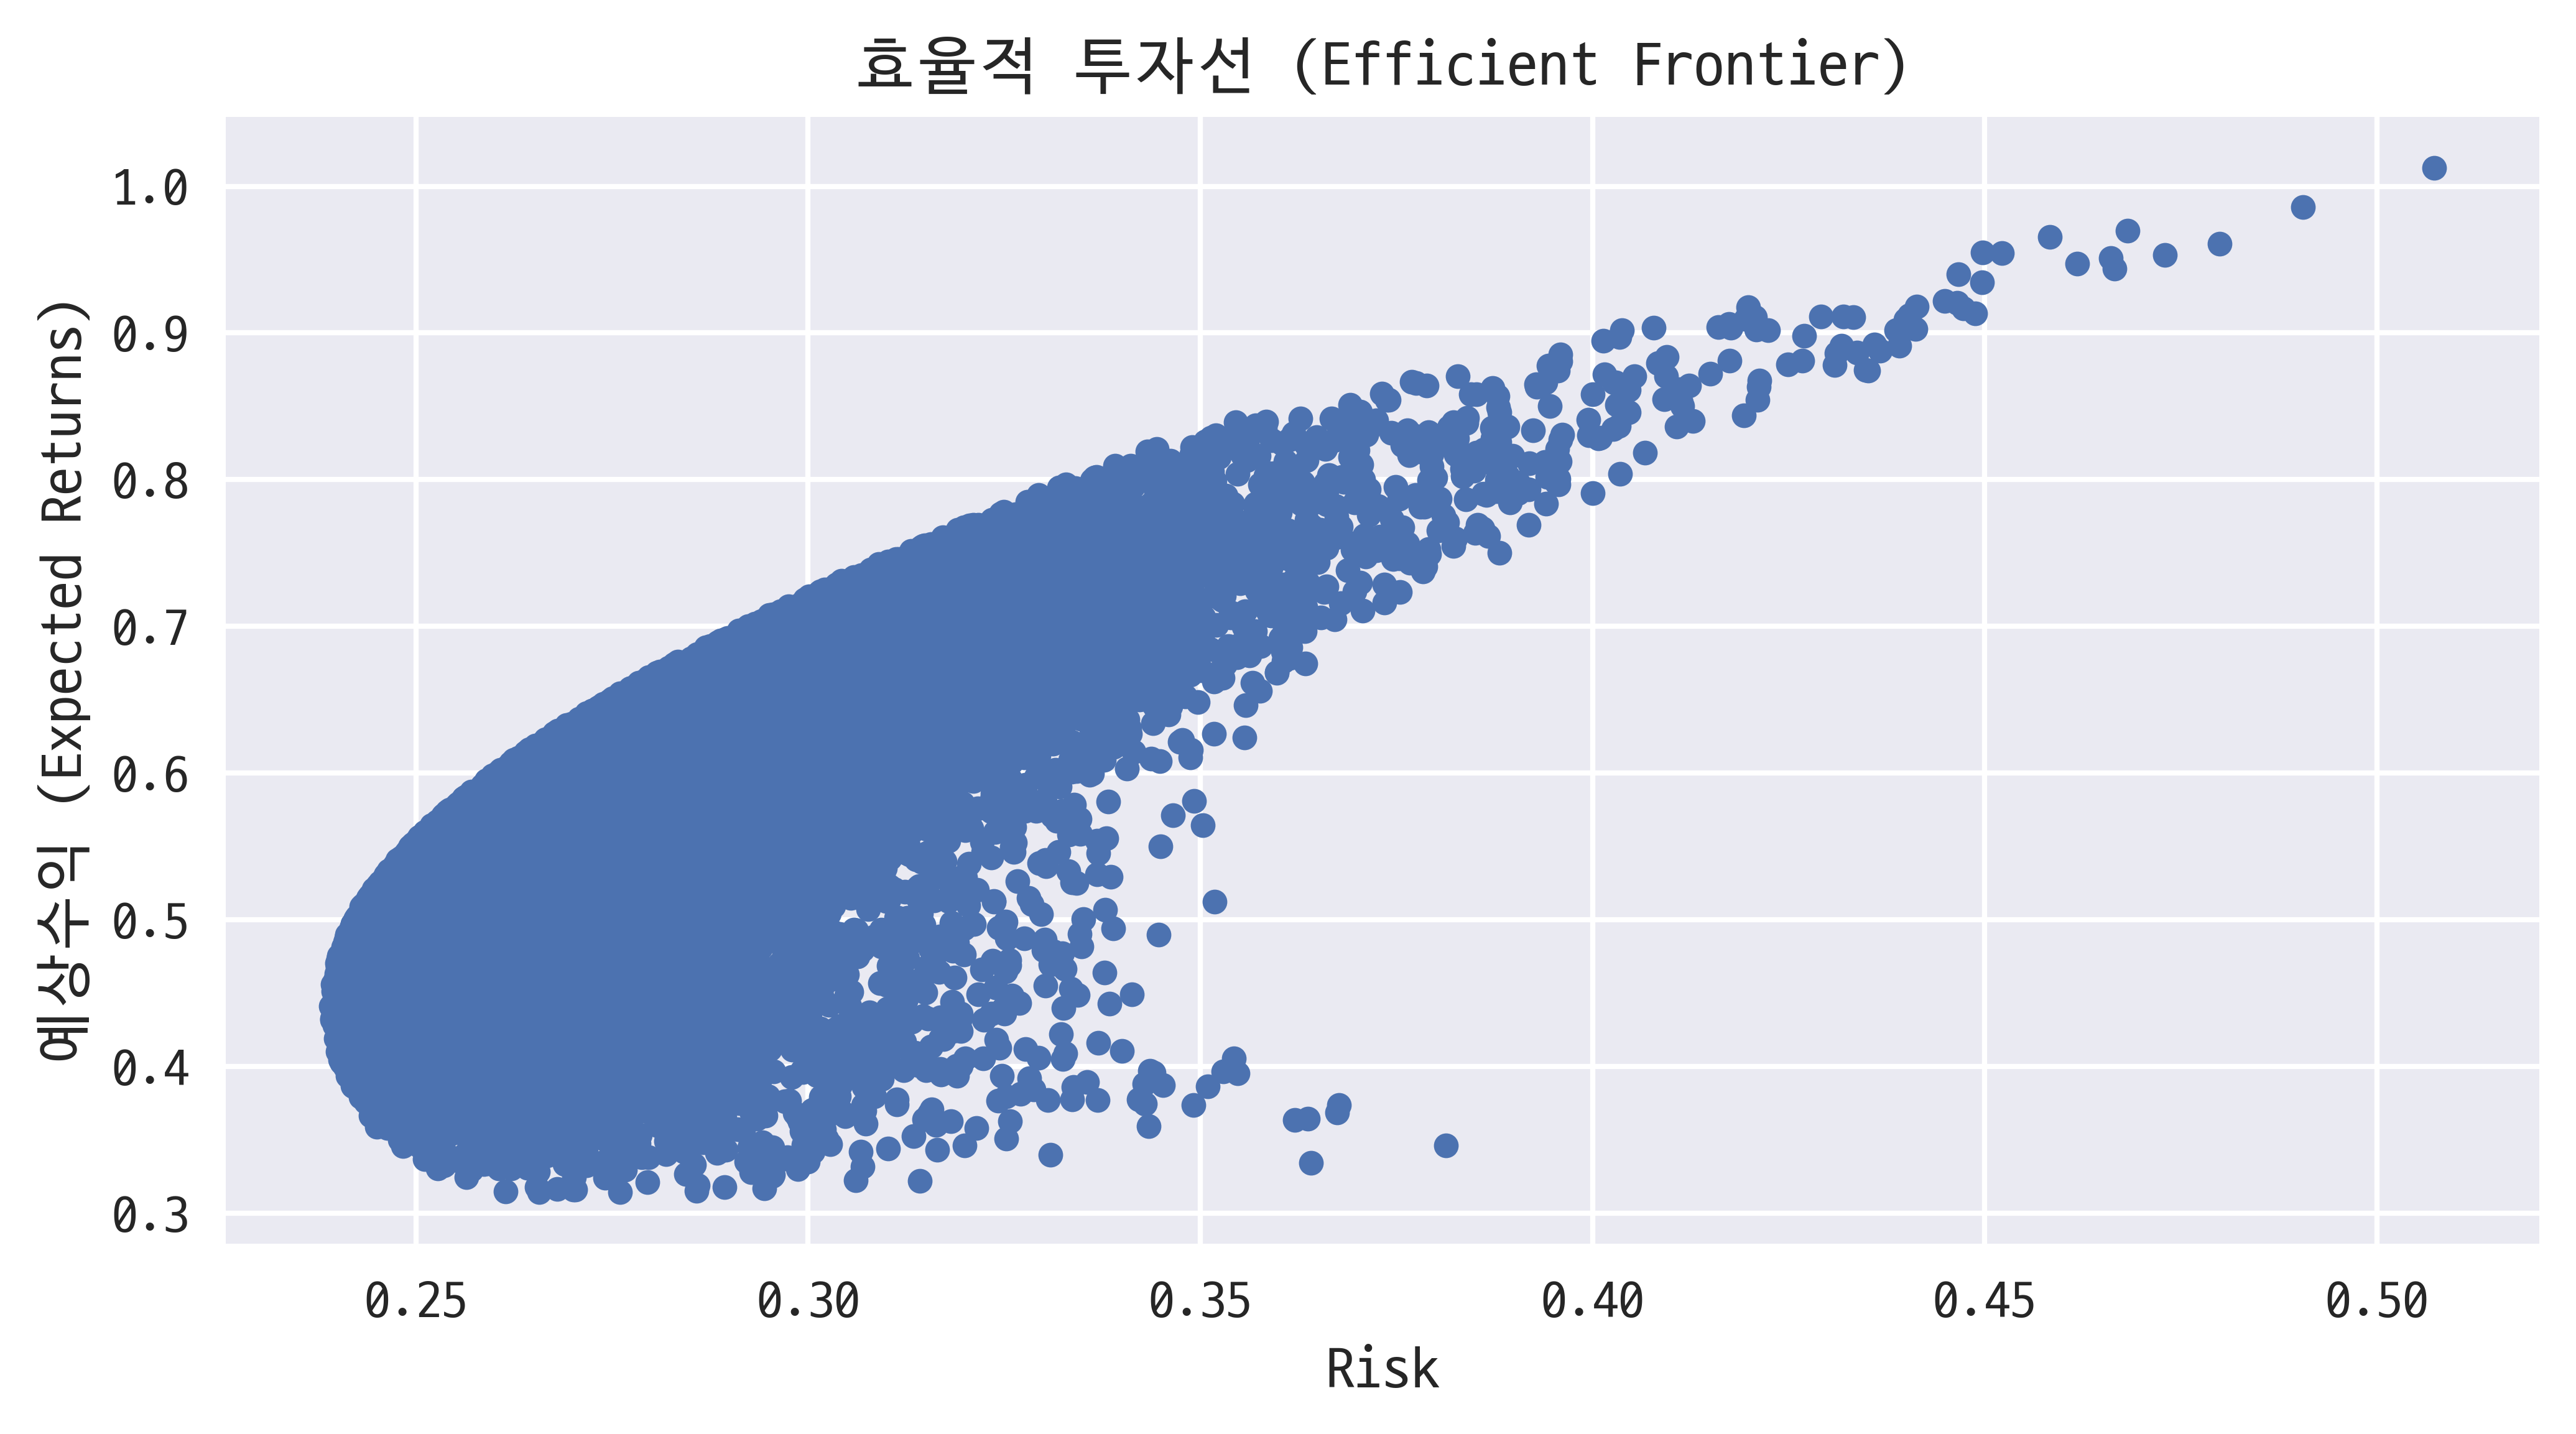

In [10]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = (20.0, 5.0)
portfolio_df.plot.scatter(x='Risk', y='Returns', figsize=(8, 4), grid=True)
plt.title('효율적 투자선 (Efficient Frontier)') 
plt.xlabel('Risk') 
plt.ylabel('예상수익 (Expected Returns)') 
plt.show() 

# **2 샤프 지수와 포트폴리오 최적화**
## **01 샤프지수**
- 측정된 위험 단위당 수익률의 계산 및 비교
- 샤프지수로 측정된 **최소위험, 최대위험** 비율을 특정 한다
- $ 사프지수 = {(포트폴리오 예상 수익률 - 무위험률) \over 수익률 표준편차} $

In [11]:
# Sharp 지수를 추가하여 시뮬레이션 실행
stocks = list(code_dict.values())
port_rate, port_risk, port_weights, sharpe_ratio = [], [], [], [] 

for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights /= np.sum(weights) 

    returns = np.dot(weights, annual_rate) 
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 

    port_rate.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights)
    sharpe_ratio.append(returns/risk) # Sharp 지수 추가

In [12]:
# Sharp 테이블 추가
portfolio = {'Returns': port_rate, 'Risk': port_risk, 'Sharpe': sharpe_ratio}
for _, s in enumerate(stocks): 
    portfolio[s] = [weight[_] for weight in port_weights] 
portfolio_df = pd.DataFrame(portfolio)
portfolio_df.tail(3)

Returns      Risk    Sharpe      삼성전자       현대차       HMM     NAVER
19997  0.657678  0.323633  2.032176  0.033105  0.405183  0.402647  0.159064
19998  0.607338  0.285682  2.125923  0.226991  0.261183  0.337972  0.173854
19999  0.535535  0.278067  1.925923  0.214409  0.376369  0.240558  0.168665

In [13]:
# 최대 리스크 포트폴리오 찾기
max_sharpe = portfolio_df.loc[portfolio_df['Sharpe'] == portfolio_df['Sharpe'].max()]
max_sharpe

Returns      Risk    Sharpe      삼성전자       현대차       HMM     NAVER
19102  0.745279  0.310135  2.403083  0.108216  0.006555  0.424272  0.460957

In [14]:
# 최소 리스크 포트폴리오 찾기
min_risk   = portfolio_df.loc[portfolio_df['Risk'] == portfolio_df['Risk'].min()]
min_risk 

Returns      Risk    Sharpe      삼성전자       현대차       HMM     NAVER
7329  0.43955  0.239145  1.838004  0.551919  0.084668  0.089609  0.273804

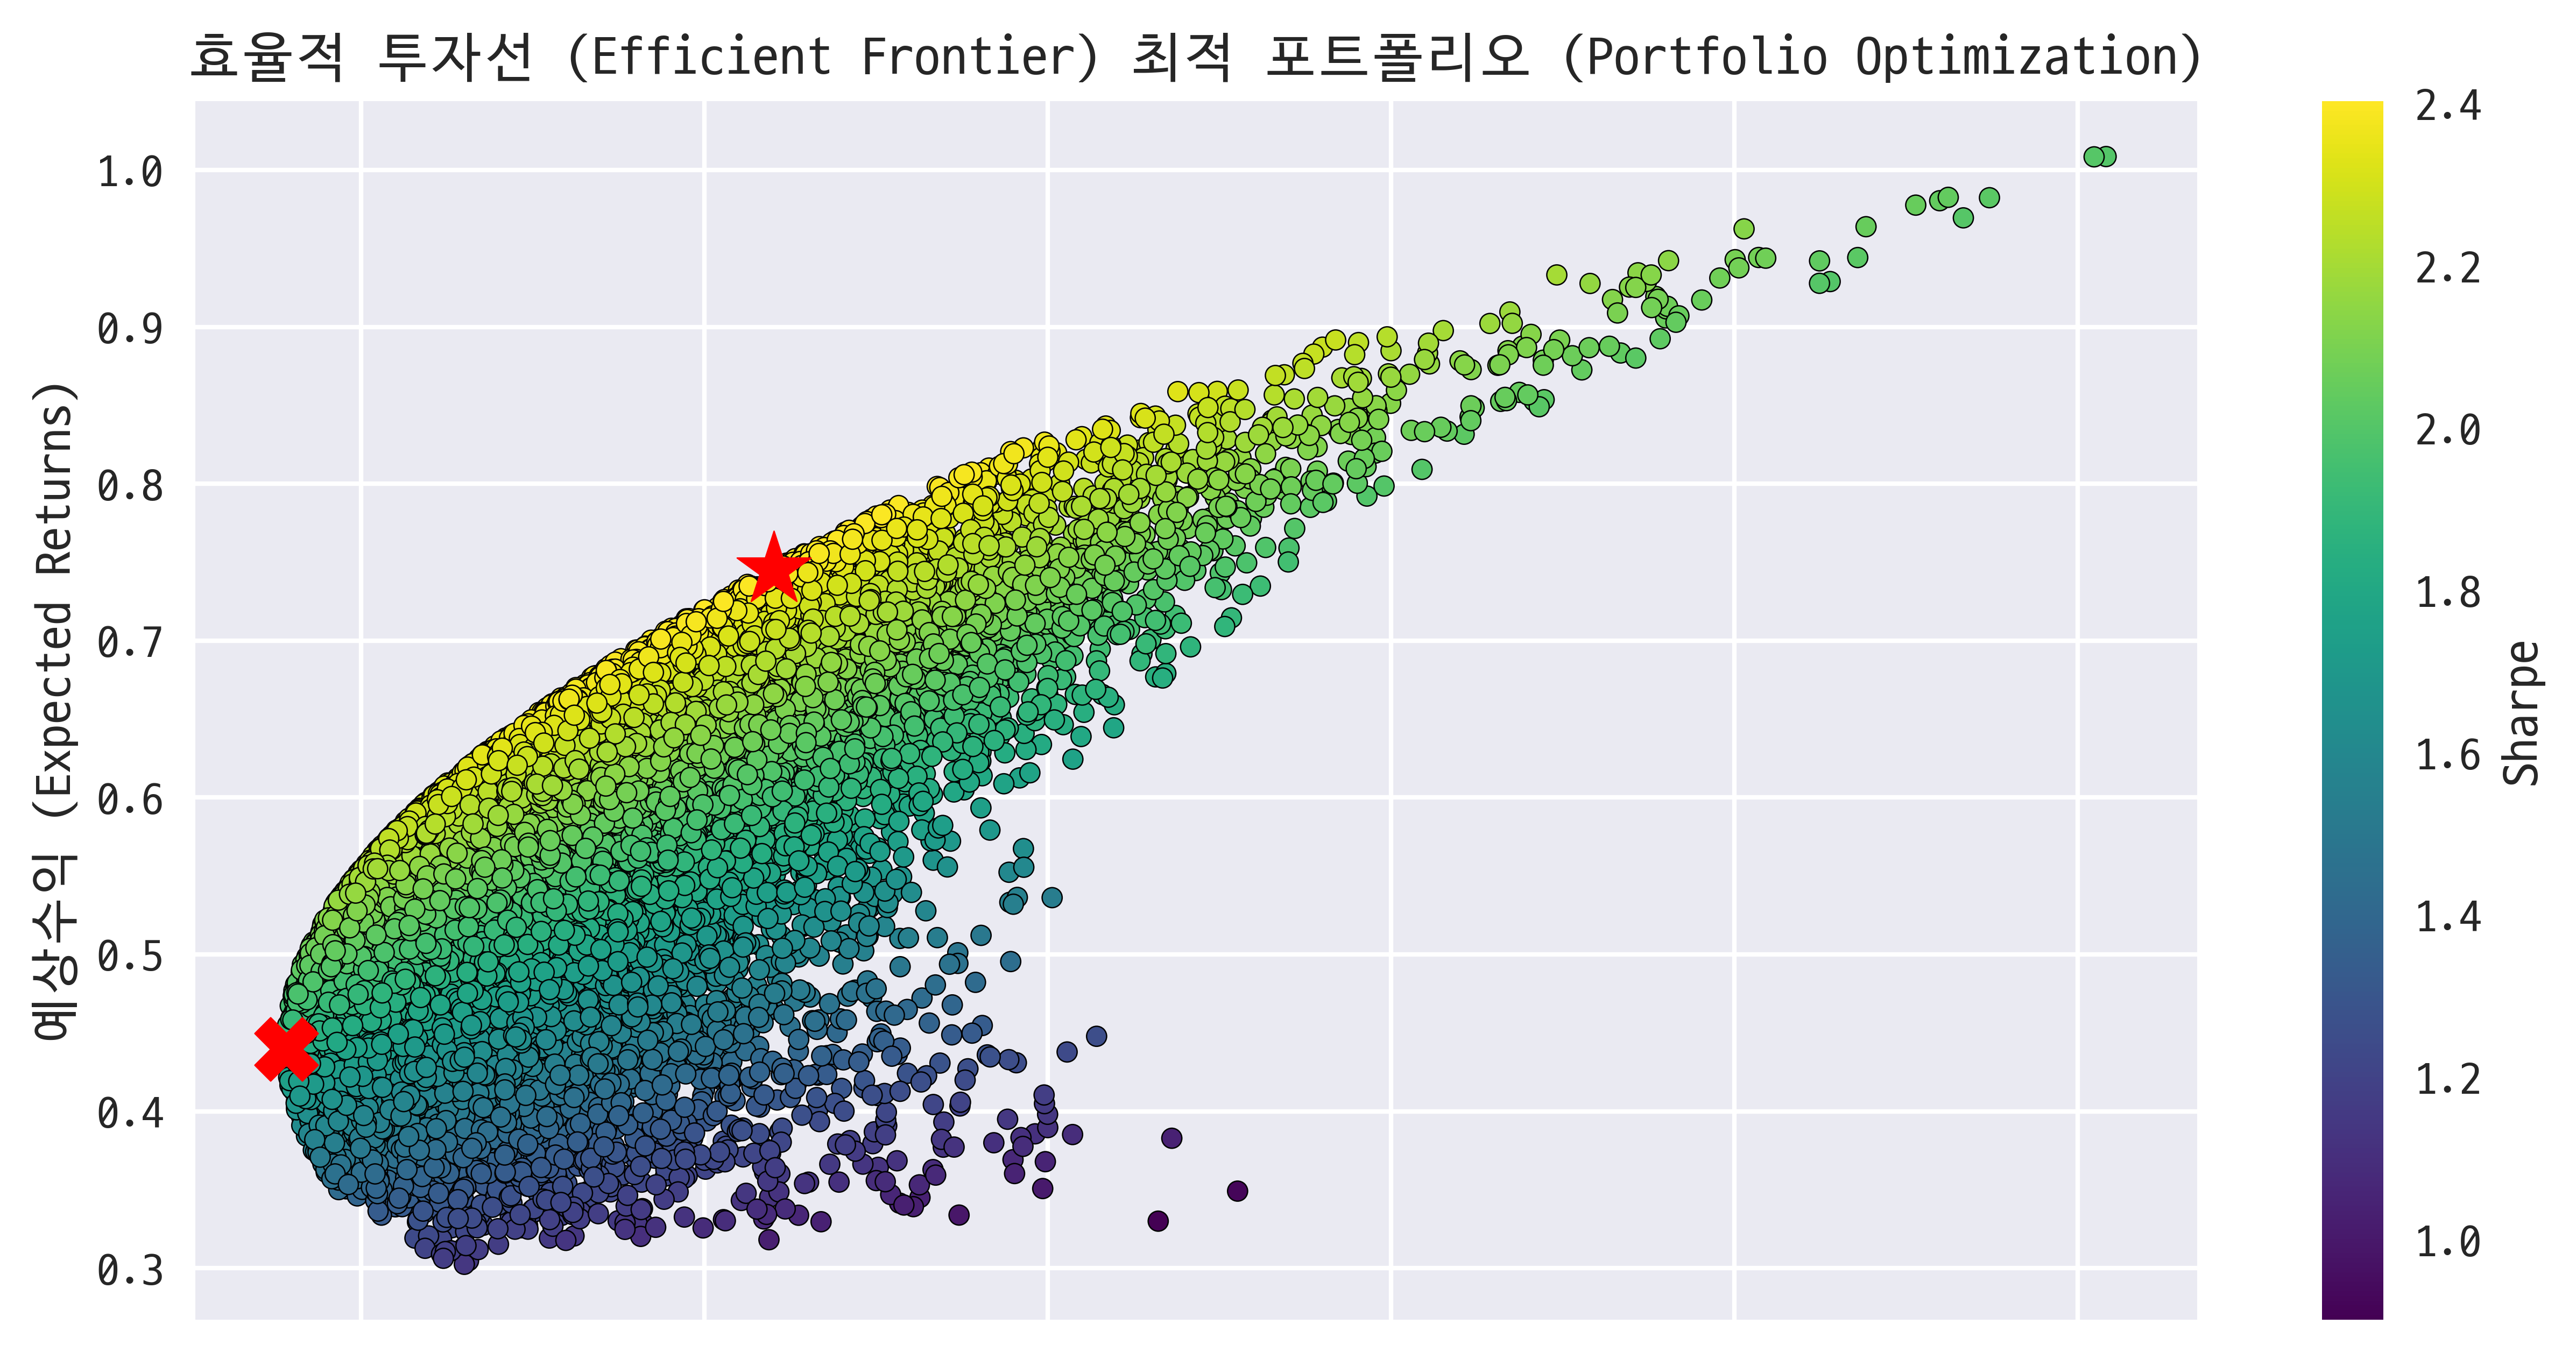

In [15]:
# 결과 시각화 출력하기
portfolio_df.plot.scatter(x='Risk', y='Returns', c='Sharpe', 
            cmap='viridis', edgecolors='k', figsize=(10,5), grid=True)

plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], 
            c='r', marker='*', s=300) # 최대 위험 / 수익구간
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], 
            c='r', marker='X', s=200) # 최소 위험 / 수익구각
plt.title('효율적 투자선 (Efficient Frontier) 최적 포트폴리오 (Portfolio Optimization)') 
plt.xlabel('Risk') 
plt.ylabel('예상수익 (Expected Returns)') 
plt.show()